In [24]:
# Importing TensorFlow
import sys

try: # Try to import or install/import
    import tensorflow as tf
except: 
    if sys.platform == "win32": 
        !pip install val
    else: 
        !{sys.executable} -m pip install val
    import tensorflow as tf

# For plotting
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [12]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)



def load_img(path_to_img):
    """Function to load an image and limit its maximum dimension to 512 pixels."""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img



def imshow(image, title=None):
    """A simple function to display an image"""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
        
def clip_0_1(image):
    """A function to keep the pixel values between 0 and 1"""
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)
        
        
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model



def gram_matrix(input_tensor):
    """Computes gram matrix for an input tensor"""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape   = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations



class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        
        super(StyleContentModel, self).__init__()
        
        self.vgg              = vgg_layers(style_layers + content_layers)
        
        self.style_layers     = style_layers
        self.content_layers   = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable    = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        
        # Scale back the pixel values
        inputs = inputs * 255.0
        
        # Preprocess them with respect to VGG19 stats
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # Pass through the mini network
        outputs = self.vgg(preprocessed_input)
        
        # Segregate the style and content representations
        style_outputs, content_outputs = (
            outputs[:self.num_style_layers], 
            outputs[self.num_style_layers:]
        )

        # Calculate the gram matrix for each layer
        style_outputs = [
            gram_matrix(style_output) 
            for style_output in style_outputs
        ]

        # Assign the content representation and gram matrix in layer-by-layer fashion
        content_dict = {
            content_name:value 
            for content_name, value in zip(self.content_layers, content_outputs)
        }

        style_dict = {
            style_name:value
            for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {'content' : content_dict, 'style' : style_dict}
    
    

def style_content_loss(outputs):
    """Basic loss function for total loss"""
    
    style_outputs   = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
            for name in style_outputs.keys()
    ])
    
    style_loss *= style_weight / num_style_layers         # NORMALIZE STEP

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
            for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers   # NORMALIZE STEP
    loss = style_loss + content_loss                      # SUM UP LOSS
    
    return loss



@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)          # Extract the features
        loss = style_content_loss(outputs)  # Calculate the loss

    grad = tape.gradient(loss, image)    # Determine gradients of the loss function w.r.t the image pixels
    opt.apply_gradients([(grad, image)]) # Update the pixels
    image.assign(clip_0_1(image))        # Clip the pixel values that fall outside the range of [0,1]
    
    

def high_pass_x_y(image):
    """For visualizing produced artifacts"""
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var



def total_variation_loss(image):
    """The regularization loss associated with image is the sum of the squares of the values"""
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))



# Update include it in the train_step function:
@tf.function()
def train_step(image, total_variation_weight = 0):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

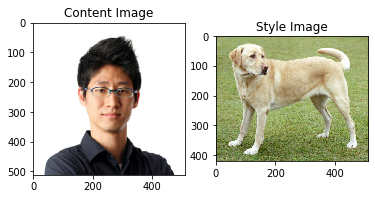

In [6]:
# Load image data
content_path = tf.keras.utils.get_file(
    fname  = 'park.jpg',
    origin = 'https://gradschool.cornell.edu/wp-content/uploads/2018/07/JonPark.jpg'
)

style_path = tf.keras.utils.get_file(
    fname  = 'YellowLabradorLooking_new.jpg', 
    origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)

content_image = load_img(content_path)
style_image = load_img(style_path)

# Show images
plt.subplot(1, 2, 1); imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2); imshow(style_image,   'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer:
 - The first few layers activations represent low-level features like edges and textures. 
 - The final few layers represent higher-level features: object parts like wheels or eyes. 

In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [27]:
# Load a VGG19 and test run it on our image to ensure it's used correctly:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

# Just test the model to make sure it's looking at the right thing
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

# Now load a VGG19 without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print()
# for layer in vgg.layers:
#     print(layer.name)
    
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

In [28]:
# Create the model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Extract style and content
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())
#     print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())


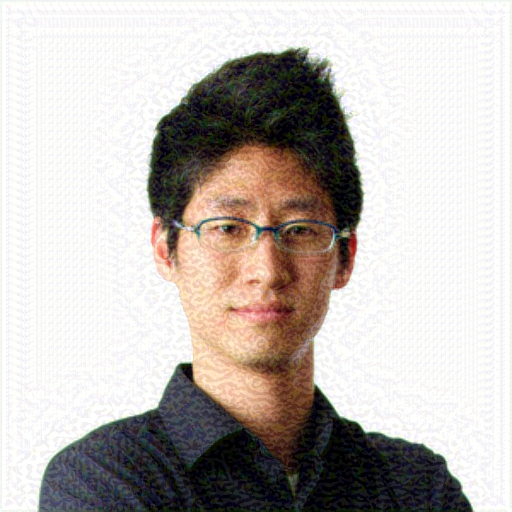

In [13]:
# Run gradient descent
# Set your style and content target values:
style_targets   = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Define a tf.Variable to contain the image to optimize.
image = tf.Variable(content_image)

# Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight   = 1e-2
content_weight = 1e4

# # A few test runs
# train_step(image)
# train_step(image)
# train_step(image)
# tensor_to_image(image)

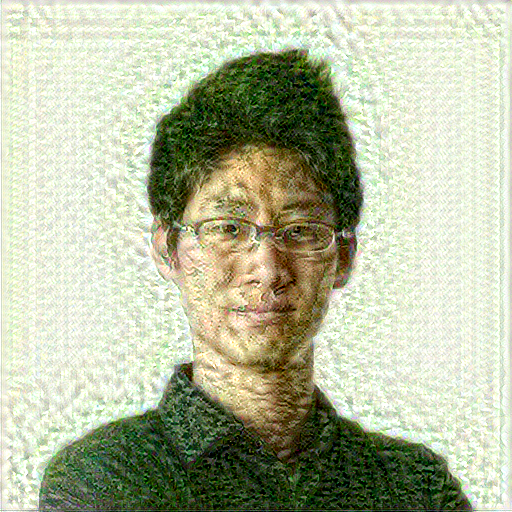

Train step: 25
Total time: 110.1


In [25]:
import time
start = time.time()

epochs = 5          # Set low for our purposes
steps_per_epoch = 5 # Set low for our purposes

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

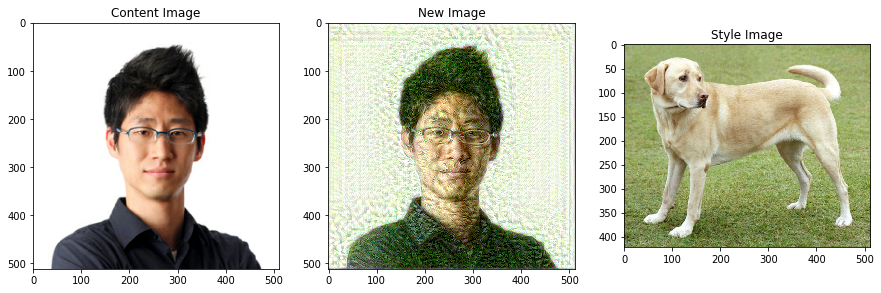

In [26]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(1, 3, 1); imshow(content_image, 'Content Image')
plt.subplot(1, 3, 2); imshow(image, 'New Image')
plt.subplot(1, 3, 3); imshow(style_image,   'Style Image')

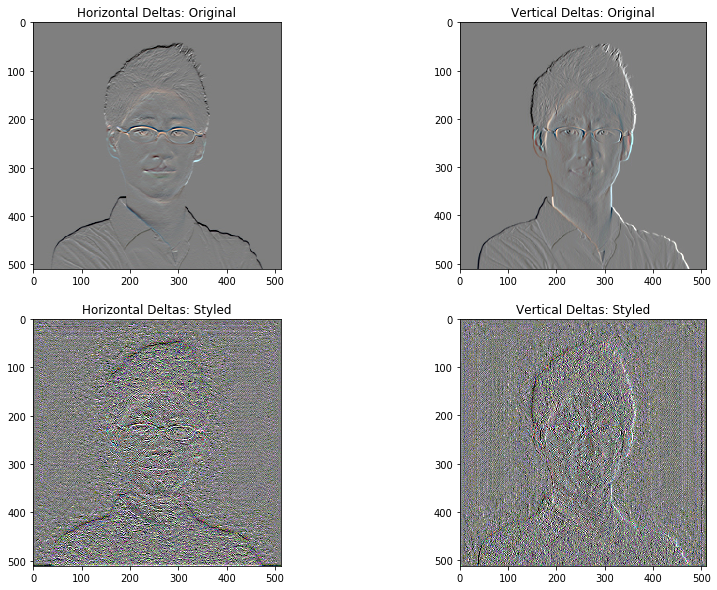

In [29]:
# The following shows how the high frequency components have increased.
# Also, this high frequency component is basically an edge-detector. 

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [30]:
# The regularization loss associated with this is the sum of the squares of the values:

# def total_variation_loss(image):  # How the below is implemented
#     x_deltas, y_deltas = high_pass_x_y(image)
#     return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

tf.image.total_variation(image).numpy()

array([89583.86], dtype=float32)

In [31]:
file_name = 'stylized-image_park.png'
tensor_to_image(image).save(file_name)

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)